# Lab 3 : Hawkes Processes : Thinning, Branching, Fitting...

Hugo Yeremian - Martin Pasche

In [2]:
import Hawkes as hk
import numpy as np
import sys,time,datetime,copy,subprocess,itertools,pickle,warnings,json,gc
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.cm import get_cmap
import pandas as pd
from tqdm import tqdm
import scipy.stats as stats 
from scipy.stats import poisson, expon
import statsmodels.api as sm
import os

## Processus de Hawkes

 **Processus de Hawkes**, processus ponctuel auto-excité qui modélise la dépendance temporelle entre les événements. Il est particulièrement utile pour modéliser les phénomènes où un événement augmente temporairement la probabilité d'occurrence d'autres événements — Ici les trades. Par exemple un trade engendré par un évènement comme une news ou un évènement particulier engendre ensuite une activité qui réagit de façon endogène aux marchés.

L’intensité conditionnelle du processus à l’instant $ t $, sachant l’historique $ H_t = \{t_i < t\} $, est donnée par :

$$
\lambda(t \mid H_t) = \mu(t) + \sum_{t_i < t} f(t - t_i)
$$

où :

- $ \mu(t) \geq 0 $ est la fonction d’intensité (background intensity), souvent constante,
- $ f(\tau) \geq 0 $ est une fonction kernel (décroissante),
- $ \{t_i\} $ sont les temps des événements précédents,
- $ \lambda(t \mid H_t) $ représente l'intensité instantanée conditionnelle.

Ici on va principalement modéliser les processus de Hawkes à l'aide d’un **noyau exponentiel**, on a :

$$
f(t - t_i) = \alpha e^{-\beta (t - t_i)} \quad \text{avec } \alpha > 0, \ \beta > 0
$$

où :
- $ \alpha $ mesure la **force d'excitation** (l’impact d’un événement),
- $ \beta $ détermine la **vitesse de décroissance** de cet impact dans le temps.

Pour garantir la **stabilité** du processus (i.e., éviter une explosion du nombre d’événements), il faut que :

$$
\frac{\alpha}{\beta} < 1
$$

Cela signifie que, en moyenne, un événement doit engendrer **moins d’un autre événement**.

Sinon on se retrouverait dans une situation où les évènements escaladeraient infiniment sans réelle décroissance.

## Partie I : L'algorithme dit de Thinning par Ogata à l'aide d'une fonction kernel décroissante :

L'algorithme de **thinning** (ou amincissement) permet de simuler un processus ponctuel non-homogène en :
1. Surestimant l'intensité avec une borne supérieure $ \bar{\lambda} $,
2. Générant des temps candidats avec une loi exponentielle de paramètre $ \bar{\lambda} $,
3. Acceptant ou rejetant chaque événement selon un test de Bernoulli de probabilité $ \lambda(t) / \bar{\lambda} $.


In [3]:
def Hawkes_Thinning(T, lambda_0, alpha, beta, seed=42, verbose=False):
    # réplication
    if not isinstance(seed, int):
        print("Warning: seed must be an integer. Using default seed=42.")
        seed = 42
    rng = np.random.default_rng(seed)
    # on store l'historique des évènements
    events = []
    t = 0
    while t < T:
        if len(events) == 0:
            # la borne de surestimation reste lambda_0
            lambda_upper = lambda_0
        else:
            # intensité instantanée par la fonction kernel exponentielle à t
            lambda_t = lambda_0 + \
                       sum(alpha * beta * np.exp(-beta * (t - ti))\
                            for ti in events)
            lambda_upper = lambda_t  # plus besoin de max, déjà ≥ lambda_0
        # incrément de temps pour le prochain candidat (t_i)
        t += rng.exponential(1 / lambda_upper)
        # vérif
        if t > T:
            break
        # recalcul de l'intensité à (t_i)
        lambda_t = lambda_0 + \
                   sum(alpha * beta * np.exp(-beta * (t - ti))\
                        for ti in events)
        # test de rejet de l'évènement à (t_i)
        if rng.uniform() < lambda_t / lambda_upper:
            events.append(t)
    return np.array(events)


### Parameters of the Ogata's Thinning Algorithm :

In [4]:
T = 100
T_max = 100

lambda_0 = 0.1
alpha = 0.4
beta = 1.0

### Simulation :

In [5]:
event_times = Hawkes_Thinning(T, lambda_0, alpha, beta)

print(f"Les 5 premiers évènements : {event_times[0:5]}")
print(f"Le nombre d'évènements est {len(event_times)}")

Les 5 premiers évènements : [24.04208604 29.64761002 33.09805546 48.37006753 48.55322203]
Le nombre d'évènements est 17


### Plotting :

Appendix : J'ai eu du mal à faire tourner les plots de la librairie Hawkes et
pour pouvoir comparer nos simulations à celles données par la lib,
j'ai transformé légèrement les plots.

In [6]:
def plot_N_enhanced(T, itv):
    plt.figure(figsize=(6, 4), dpi=120)
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.2, 3], hspace=0.3)
    [st, en] = itv
    n = len(T)

    ax0 = plt.subplot(gs[0])
    for t in T:
        ax0.plot([t, t], [0, 1], color='dodgerblue', linewidth=1)
    ax0.set_xlim(itv)
    ax0.set_ylim([0, 1])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title("Event Raster")
    ax0.spines[['top', 'right', 'left']].set_visible(False)

    # N(t) process
    ax1 = plt.subplot(gs[2])
    x = np.hstack([st, np.repeat(T, 2), en])
    y = np.repeat(np.arange(n + 1), 2)
    ax1.plot(x, y, '-', color='black', linewidth=1.2)
    ax1.set_xlim(itv)
    ax1.set_ylim([0, n])
    ax1.set_xlabel('Time')
    ax1.set_ylabel(r'$N(0,t)$')
    ax1.grid(True, linestyle=':', linewidth=0.5)
    ax1.spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()

In [7]:
def plot_l_enhanced(T, x, l, l_baseline):
    plt.figure(figsize=(6, 4), dpi=120)
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.2, 3], hspace=0.3)
    l_max = max(l.max(), l_baseline.max())

    # Raster plot
    ax0 = plt.subplot(gs[0])
    for t in T:
        ax0.plot([t, t], [0, 1], color='dodgerblue', linewidth=1)
    ax0.set_xlim([x[0], x[-1]])
    ax0.set_ylim([0, 1])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title("Event Raster")
    ax0.spines[['top', 'right', 'left']].set_visible(False)

    # Intensity plot
    ax1 = plt.subplot(gs[2])
    ax1.plot(x, l, label=r'$\lambda(t|H_t)$', color='black', lw=1.5)
    ax1.plot(x, l_baseline, label='Baseline', linestyle='--', color='gray', lw=1)
    ax1.set_xlim([x[0], x[-1]])
    ax1.set_ylim([0, l_max * 1.05])
    ax1.set_xlabel('Time')
    ax1.set_ylabel(r'$\lambda(t|H_t)$')
    ax1.grid(True, linestyle=':', linewidth=0.5)
    ax1.legend(frameon=False)
    ax1.spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()

### Helper Function for the plot of the library (not included in our simulation)

In [8]:
def compute_intensity_over_time(event_times,
                                T,
                                lambda_0,
                                alpha,
                                beta,
                                resolution=10_000):
    
    t_vals = np.linspace(0, T, resolution)
    lambda_vals = []
    for t in t_vals:
        l = lambda_0 + sum(alpha * np.exp(-beta * (t - ti)) \
                           for ti in event_times if ti < t)
        
        lambda_vals.append(l)
    lambda_vals = np.array(lambda_vals)
    baseline = np.full_like(lambda_vals, lambda_0)
    return t_vals, lambda_vals, baseline

C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\2405523555.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


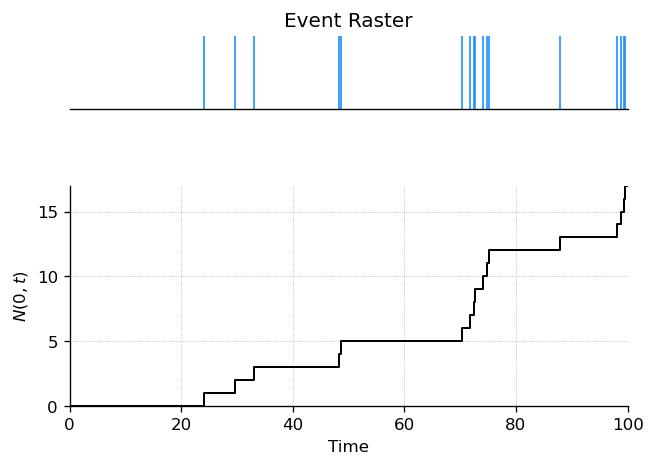

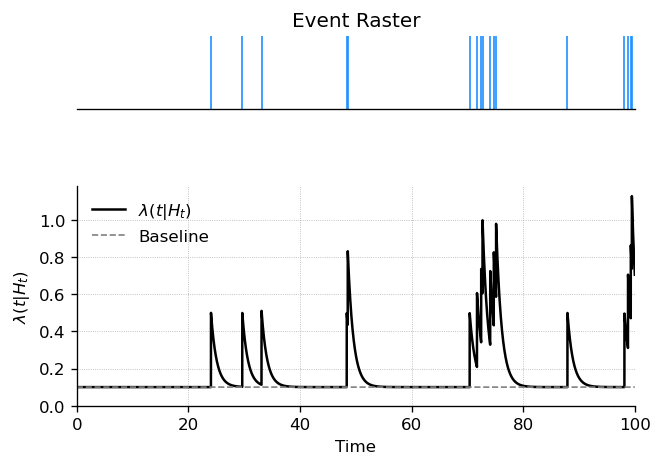

In [9]:
t_grid, lambda_t, baseline = compute_intensity_over_time(event_times,
                                                        T,
                                                        lambda_0,
                                                        alpha,
                                                        beta)

plot_N_enhanced(event_times, [0, T])
plot_l_enhanced(event_times, t_grid, lambda_t, baseline)

## Avec la Librairie Hawkes : Thinning Ogata Simulation

In [10]:
para = {"mu": 0.1, "alpha": 0.4, "beta": 1.0}
itv = [0, 100]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print("5 premiers évènements", T[:5] )
print("Number of events:", len(T))

h2 = hk.estimator().set_kernel('exp').set_baseline('const')
h2.fit(T, itv)
#print("Estimated parameters:", h2.para)

#print()
#%timeit -n1 -r1 h2.fit(T, itv)


5 premiers évènements [ 4.03886778 30.31377699 30.65071829 31.04824789 43.56710938]
Number of events: 17


### Plotting :

C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\2405523555.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


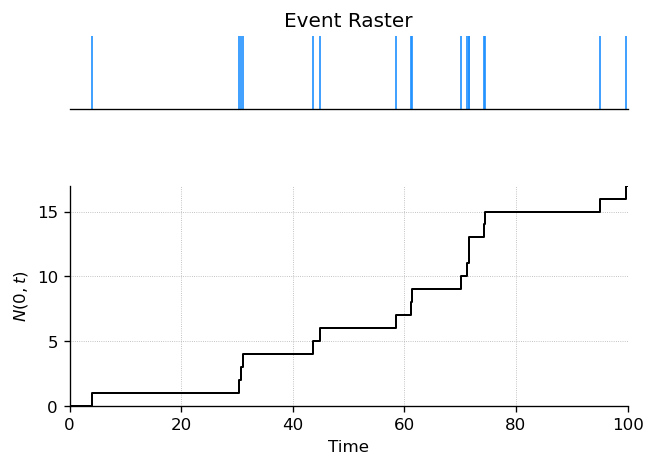

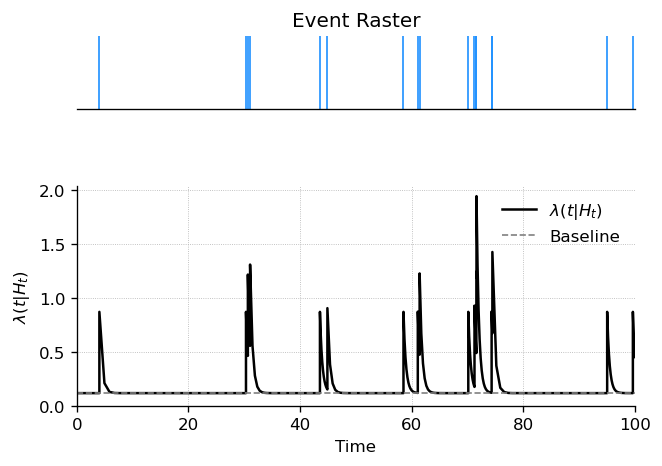

In [11]:
plot_N_enhanced(T, itv)
t, l, l_baseline = h2.tl()
plot_l_enhanced(T, t, l, l_baseline)

## Partie I.2 : L'algorithme dit de Branching à l'aide d'une fonction kernel décroissante :

## Algorithme de Branching pour le Processus de Hawkes

Contrairement à l'algorithme de *thinning* qui simule un processus de Poisson non homogène, l'algorithme de *branching* interprète le processus de Hawkes comme un **processus de Poisson clusterisé**.

- Les **immigrants** arrivent selon un processus de Poisson homogène de taux $ \mu $ (intensité de base).
- Chaque immigrant peut générer des **descendants** selon une fonction de noyau $ f(\cdot) $, typiquement de forme exponentielle.
- Ces descendants peuvent à leur tour générer d'autres événements, de manière récursive.

L’intensité moyenne de reproduction (ou **taux de branchement**) est :

$$
\eta = \int_0^\infty f(s) \, ds = \frac{\alpha}{\beta}
$$

Le processus est **stable** si $ \eta < 1 $ comme pour l'algorithme de thinning

Cette approche permet de visualiser le processus comme une forêt d’arbres d’événements : chaque événement peut en engendrer d’autres, formant des **chaînes de causalité**.


In [12]:
# Génère les événements immigrants selon un processus de
# Poisson homogène de taux lambda_0
def generate_immigrants(lmbda_0, Tmax):
    times = []
    t = 0
    while True:
        # Tirage du temps d'arrivée du prochain immigrant
        t += np.random.exponential(1.0 / lmbda_0)
        if t > Tmax:
            break
        times.append(t)
    return np.array(times)

# Génère les enfants (descendants) d'un parent donné selon le noyau choisi
def generate_offspring(parent_time, kernel_func, kernel_max, Tmax):
    offspring = []
    t = parent_time
    while True:
        # Tirage d’un temps candidat à partir d’un processus
        # de Poisson de taux majorant
        t += np.random.exponential(1.0 / kernel_max)
        if t > Tmax:
            break
        # Acceptation par thinning avec proba f(t - parent_time) / max
        if np.random.rand() < kernel_func(t - parent_time) / kernel_max:
            offspring.append(t)
    return offspring


# Simule un processus de Hawkes en utilisant l’approche par branching
#  (processus de Poisson clusterisé)
def simulate_hawkes_branching(lmbda_0, alpha, beta, Tmax):
    immigrants = generate_immigrants(lmbda_0, Tmax)
    # On initialise la liste des événements avec les immigrants
    events = list(immigrants)
    # Génération associée à chaque événement (0 pour les immigrants)
    generations = [0] * len(immigrants)
    queue = [(t, 0) for t in immigrants]
    kernel_func = lambda t: alpha * beta * np.exp(-beta * t)
    kernel_max = alpha * beta
    while queue:
        parent_time, parent_gen = queue.pop()
        children = generate_offspring(parent_time, kernel_func, kernel_max, Tmax)
        events.extend(children)
        generations.extend([parent_gen + 1] * len(children))
        queue.extend([(child, parent_gen + 1) for child in children])

    sorted_idx = np.argsort(events)
    events = np.array(events)[sorted_idx]
    generations = np.array(generations)[sorted_idx]

    return events, generations


In [13]:
events, generations = simulate_hawkes_branching(
    lmbda_0=lambda_0,
    alpha=alpha,
    beta = beta,
    Tmax=T_max)

print("Generated 5 first events", events[:5]) 
print("Generated", len(events), "events.")

Generated 5 first events [0.65601747 4.18928248 4.92353456 5.56974651 6.75440226]
Generated 32 events.


In [14]:
def plot_branching_colored(T, generations, itv):
    """
    Plot event raster and N(t) with generation color coding.
    
    Parameters:
        T : array-like
            Event times.
        generations : array-like
            Same length as T. Generation number (0 = immigrant, 1 = first-gen...)
        itv : tuple
            Time interval (start, end).
    """
    T = np.array(T)
    generations = np.array(generations)
    [st, en] = itv
    n = len(T)

    # Normalize generations to colors
    gen_unique = np.unique(generations)
    cmap = get_cmap("viridis", len(gen_unique))
    color_dict = {g: cmap(i) for i, g in enumerate(gen_unique)}

    plt.figure(figsize=(6, 4), dpi=120)
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.2, 3], hspace=0.3)

    # Raster plot with generations
    ax0 = plt.subplot(gs[0])
    for t, g in zip(T, generations):
        ax0.plot([t, t], [0, 1], color=color_dict[g], linewidth=1)
    ax0.set_xlim(itv)
    ax0.set_ylim([0, 1])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title("Event Raster by Generation")
    ax0.spines[['top', 'right', 'left']].set_visible(False)

    # N(t) plot
    ax1 = plt.subplot(gs[2])
    x = np.hstack([st, np.repeat(T, 2), en])
    y = np.repeat(np.arange(n + 1), 2)
    ax1.plot(x, y, '-', color='black', linewidth=1.2)
    ax1.set_xlim(itv)
    ax1.set_ylim([0, n])
    ax1.set_xlabel('Time')
    ax1.set_ylabel(r'$N(0,t)$')
    ax1.grid(True, linestyle=':', linewidth=0.5)
    ax1.spines[['top', 'right']].set_visible(False)

    # Legend
    handles = [plt.Line2D([0], [0], color=color_dict[g], lw=2,\
                           label=f'Gen {g}') for g in gen_unique]
    ax1.legend(handles=handles, title="Generations", frameon=False)

    plt.tight_layout()
    plt.show()


C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\164711416.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis", len(gen_unique))
C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\164711416.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


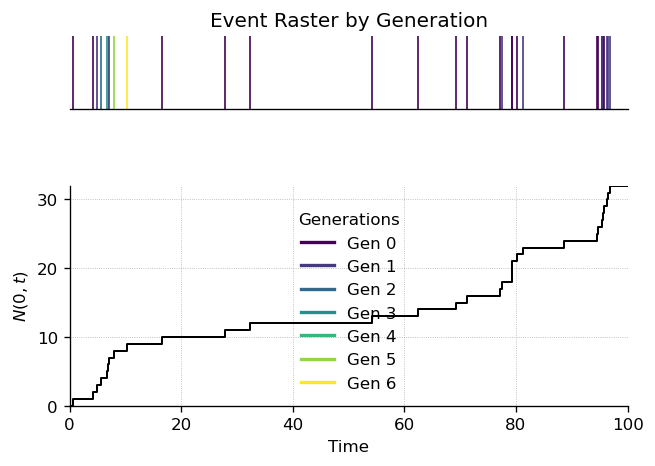

In [15]:
plot_branching_colored(events, generations, itv=[0, 100])

## Helper Function

In [16]:
def compute_intensity_from_events(T, kernel_func, lambda_0, t_grid):
    """
    Reconstruct intensity λ(t) over time grid using branching process output.
    
    Parameters:
        T : array of event times
        kernel_func : function ν(t)
        lambda_0 : float, baseline intensity
        t_grid : np.array of time points

    Returns:
        l : np.array, total intensity λ(t)
        l_baseline : np.array, constant baseline over time
    """
    l = np.full_like(t_grid, fill_value=lambda_0, dtype=float)

    for ti in T:
        mask = t_grid > ti
        l[mask] += kernel_func(t_grid[mask] - ti)

    return l, np.full_like(t_grid, lambda_0)


In [17]:
x = np.linspace(0, 100, 1000)
nu = lambda t: alpha * beta * np.exp(-beta * t)
l, l_baseline = compute_intensity_from_events(events,
                                             kernel_func=nu,
                                             lambda_0=0.2,
                                             t_grid=x)

In [18]:
def plot_l_colored_by_generation(T, generations, x, l, l_baseline):
    """
    Plot raster + intensity for branching Hawkes process, colored by generation.

    Parameters:
        T : list or np.ndarray
            Event times.
        generations : list or np.ndarray
            Generation number for each event (same length as T).
        x : np.ndarray
            Time grid for intensity.
        l : np.ndarray
            Reconstructed intensity λ(t).
        l_baseline : np.ndarray
            Baseline intensity (e.g., constant λ₀).
    """
    T = np.array(T)
    generations = np.array(generations)
    l_max = max(l.max(), l_baseline.max())
    gen_unique = np.unique(generations)
    cmap = get_cmap("viridis", len(gen_unique))
    color_dict = {g: cmap(i) for i, g in enumerate(gen_unique)}

    plt.figure(figsize=(6, 4), dpi=120)
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.2, 3], hspace=0.3)

    # Top: Raster with generation colors
    ax0 = plt.subplot(gs[0])
    for t, g in zip(T, generations):
        ax0.plot([t, t], [0, 1], color=color_dict[g], linewidth=1)
    ax0.set_xlim([x[0], x[-1]])
    ax0.set_ylim([0, 1])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title("Event Raster by Generation")
    ax0.spines[['top', 'right', 'left']].set_visible(False)

    # Bottom: Intensity curve
    ax1 = plt.subplot(gs[2])
    ax1.plot(x, l, label=r'$\lambda(t|H_t)$', color='black', lw=1.5)
    ax1.plot(x, l_baseline, label='Baseline', linestyle='--', color='gray', lw=1)
    ax1.set_xlim([x[0], x[-1]])
    ax1.set_ylim([0, l_max * 1.05])
    ax1.set_xlabel('Time')
    ax1.set_ylabel(r'$\lambda(t|H_t)$')
    ax1.grid(True, linestyle=':', linewidth=0.5)
    ax1.legend(frameon=False)
    ax1.spines[['top', 'right']].set_visible(False)

    # Legend for generations
    handles = [plt.Line2D([0], [0], color=color_dict[g], lw=2,\
                           label=f'Gen {g}') for g in gen_unique]
    ax1.legend(handles=handles, title="Generations", frameon=False)

    plt.tight_layout()
    plt.show()

C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\3991940162.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis", len(gen_unique))
C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\3991940162.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


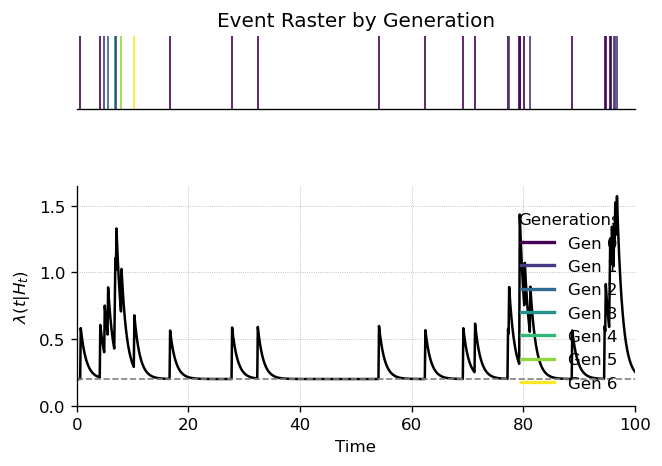

In [19]:
plot_l_colored_by_generation(events, generations, x, l, l_baseline)

In [20]:
Ts = [1, 10, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 50_000]
lambda_0 = 0.1
alpha = 0.4
beta = 1.0
para = {"mu": lambda_0, "alpha": alpha, "beta": beta}

manual_hawkes_thinning_times = []
lib_hawkes_thinning_times = []
manual_hawkes_branching_times = []

for i in tqdm(range(len(Ts)), desc="Simulation Times"):
    T = Ts[i]
    # Hawkes Thinning
    start_time = time.time()
    event_times = Hawkes_Thinning(T, lambda_0, alpha, beta)
    manual_hawkes_thinning_times.append(time.time() - start_time)

    # Hawkes Thinning with library
    start_time = time.time()
    h1 = hk.simulator().set_kernel(
        'exp').set_baseline('const').set_parameter(para)
    T_sim = h1.simulate([0, T])
    lib_hawkes_thinning_times.append(time.time() - start_time)

    # Hawkes Branching
    start_time = time.time()
    events, generations = simulate_hawkes_branching(lambda_0, 
                                                    alpha, beta, Tmax=T)
    manual_hawkes_branching_times.append(time.time() - start_time)

Simulation Times: 100%|██████████| 11/11 [09:19<00:00, 50.87s/it]


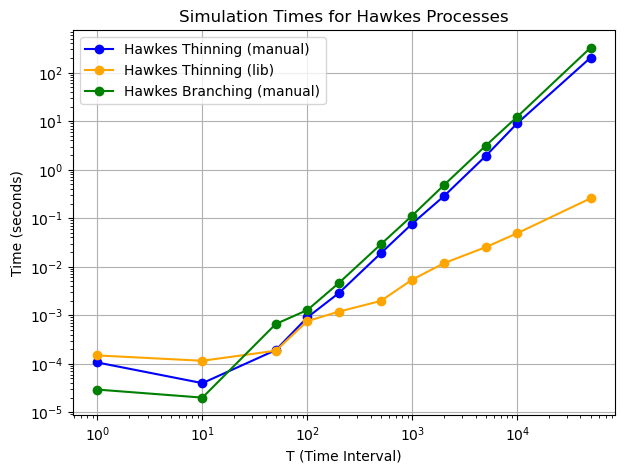

In [21]:
df_times = pd.DataFrame({
    "Hawkes Thinning (manual)": manual_hawkes_thinning_times,
    "Hawkes Thinning (lib)": lib_hawkes_thinning_times,
    "Hawkes Branching (manual)": manual_hawkes_branching_times
}, index=Ts)

plt.figure(figsize=(7, 5))
plt.plot(df_times.index, df_times["Hawkes Thinning (manual)"], marker='o', 
         label='Hawkes Thinning (manual)', color='blue')
plt.plot(df_times.index, df_times["Hawkes Thinning (lib)"], marker='o', 
         label='Hawkes Thinning (lib)', color='orange')
plt.plot(df_times.index, df_times["Hawkes Branching (manual)"], marker='o', 
         label='Hawkes Branching (manual)', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T (Time Interval)')
plt.ylabel('Time (seconds)')
plt.title('Simulation Times for Hawkes Processes')
plt.legend()
plt.grid(True)
plt.show()

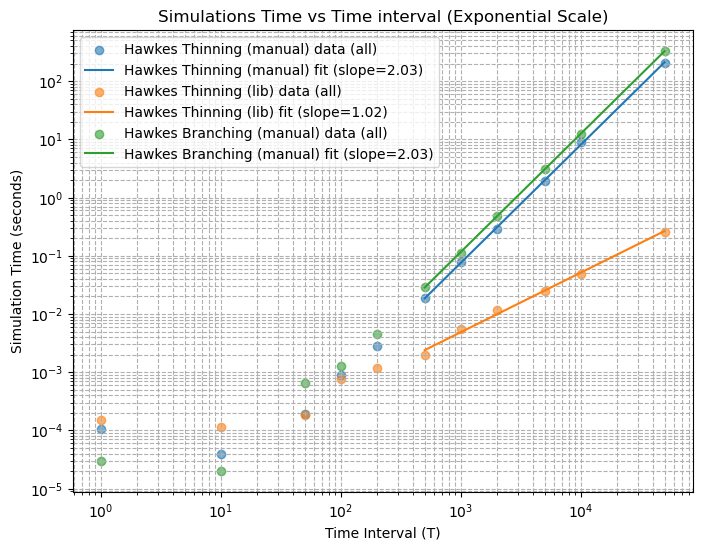

In [22]:
df_filtered = df_times[df_times.index > 200]
plt.figure(figsize=(8,6))
for col in df_times.columns:
    # Scatter plot: using all data points in df_times
    X_all = df_times.index.values.astype(float)
    y_all = df_times[col].values.astype(float)
    plt.scatter(X_all, y_all, label=f'{col} data (all)', alpha=0.6)
    
    # Regression fit: using filtered data only (for better linearity in the log-domain)
    X_vals = df_filtered.index.values.astype(float)
    y_vals = df_filtered[col].values.astype(float)
    logX = np.log(X_vals).reshape(-1, 1)
    logY = np.log(y_vals).reshape(-1, 1)
    X_design = sm.add_constant(logX)
    model = sm.OLS(logY, X_design).fit()
    intercept, slope = model.params

    # Compute the prediction in the original scale:
    # log(y) = intercept + slope * log(x)  =>  y = exp(intercept)*x^(slope)
    X_fit = np.linspace(X_vals.min(), X_vals.max(), 100)
    y_fit = np.exp(intercept) * (X_fit ** slope)
    
    plt.plot(X_fit, y_fit, label=f'{col} fit (slope={slope:.2f})')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time Interval (T)")
plt.ylabel("Simulation Time (seconds)")
plt.title("Simulations Time vs Time interval (Exponential Scale)")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

We can conclude that the time complexity of each algorithm with respect to the time horizon is:

•⁠  ⁠*Manual Thinning*: $O(T^{1.9})$
•⁠  ⁠*Lib Thinning*: $O(T^{0.97})$
•⁠  ⁠*Manual Branching*: $O(T^{1.99})$

Where $T$ is the time horizon of the simulation. The library is significantly faster than the manual implementations, especially for large time horizons. The branching algorithm is slower than the thinning algorithm, but it provides a more accurate representation of the Hawkes process in certain scenarios.

# Part II:

## Estimation des paramètres par Maximum de Vraisemblance (MLE)

- On commence par **simuler des données** à l’aide de notre simulateur (par *thinning* ou *branching*), puis on tente de **réestimer les paramètres** $ \mu, \alpha, \beta $ en utilisant la méthode du **Maximum de Vraisemblance (MLE)**.

- L’objectif de la méthode MLE est de retrouver les paramètres du processus de Hawkes $ (\mu, \alpha, \beta) $ qui **expliquent au mieux les temps d’événements observés**.


Étant donnée la séquence de temps $t_1, t_2, \ldots$, quelle est la meilleure estimation de $\mu, \alpha, \beta$ qui aurait le plus vraisemblablement généré ces événements ?


## Estimation via Thinning Algorithm (hard coded)

In [23]:
def test_mle_on_thinning_simulator(
    true_para={"mu": 0.1, "alpha": 0.4, "beta": 1.0},
    itv=[0, 1000],
    num_runs=1000,
    verbose=False
):
    def get_param(x):
        if isinstance(x, (list, np.ndarray)):
            return x[0]
        return x

    mu = true_para["mu"]
    alpha = true_para["alpha"]
    beta = true_para["beta"]

    estimates = []

    for i in tqdm(range(num_runs), desc="Thinning MLE"):
        # Simulation des événements via l'algorithme de thinning
        events = Hawkes_Thinning(itv[1], mu, alpha, beta, seed=i)
        T = events[(events > itv[0]) & (events < itv[1])]

        if len(T) < 5:
            if verbose:
                print(f"Run {i}: trop peu d’événements ({len(T)}), ignoré.")
            continue

        # Estimation MLE avec tick/hk
        h2 = hk.estimator().set_kernel('exp').set_baseline('const')
        try:
            h2.fit(T, itv)
            est_para = h2.para
            estimates.append([
                get_param(est_para["mu"]),
                get_param(est_para["alpha"]),
                get_param(est_para["beta"])
            ])
        except Exception as e:
            if verbose:
                print(f"Run {i} failed: {e}")
            continue

    if not estimates:
        print("\n Aucune estimation réussie. Essayez d'augmenter μ ou Tmax.")
        return None

    estimates = np.array(estimates)
    df = pd.DataFrame(estimates, columns=["mu", "alpha", "beta"])

    print(f"\n Simulations réussies : {len(df)} sur {num_runs}")
    print("Paramètres vrais :", true_para)
    print("\nMoyennes estimées :\n", df.mean())
    print("\nÉcarts-types :\n", df.std())
    print("\nBiais (moyenne - vrai) :\n", df.mean() - pd.Series(true_para))

    # Visualisation des distributions estimées
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, param in enumerate(["mu", "alpha", "beta"]):
        axs[i].hist(df[param], bins=20, color='skyblue', edgecolor='k', alpha=0.7)
        axs[i].axvline(true_para[param], color='red', linestyle='--', label='True')
        axs[i].set_title(f"Estimates of {param}")
        axs[i].legend()
    plt.tight_layout()
    plt.show()

    return df


Thinning MLE: 100%|██████████| 1000/1000 [01:19<00:00, 12.51it/s]



 Simulations réussies : 1000 sur 1000
Paramètres vrais : {'mu': 0.1, 'alpha': 0.4, 'beta': 1.0}

Moyennes estimées :
 mu       0.100491
alpha    0.392812
beta     1.047028
dtype: float64

Écarts-types :
 mu       0.012603
alpha    0.068091
beta     0.298219
dtype: float64

Biais (moyenne - vrai) :
 mu       0.000491
alpha   -0.007188
beta     0.047028
dtype: float64


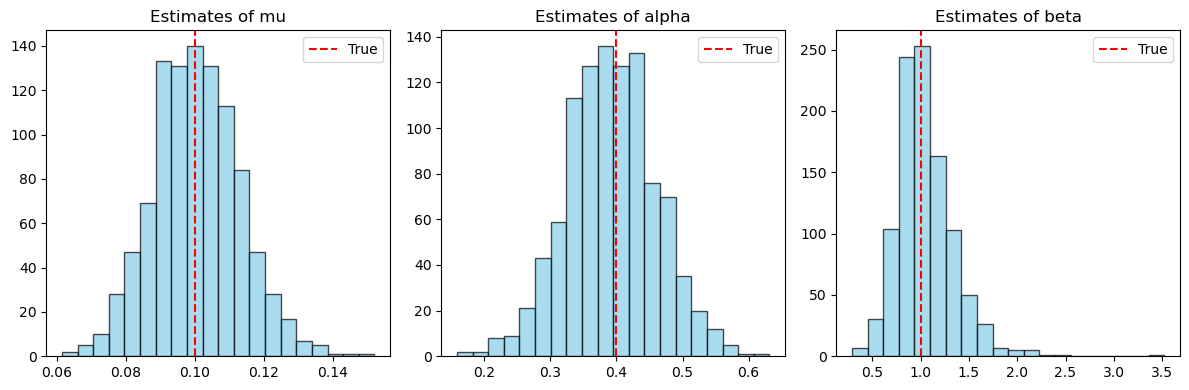

In [24]:
df_thinning = test_mle_on_thinning_simulator(
    true_para={"mu": 0.1, "alpha": 0.4, "beta": 1.0},
    itv=[0, 1000],
    num_runs=1000,
    verbose=True
)

### Simulation par la librairie Hawkes

In [25]:
def test_mle_statistics(
    true_para={"mu": 0.1, "alpha": 0.4, "beta": 1.0},
    itv=[0, 1000],
    num_runs=1000,
    verbose=False
):

    def get_param(x):
        if isinstance(x, (list, np.ndarray)):
            return x[0]
        return x

    estimates = []
    for i in tqdm(range(num_runs), desc="Estimating"):
        # can't be cut to 80 chracaters : the end is set_parameter(true_para)
        h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(true_para)
        T = h1.simulate(itv)

        if len(T) < 5:
            if verbose:
                print(f"Run {i}: too few events ({len(T)}), skipped.")
            continue

        h2 = hk.estimator().set_kernel('exp').set_baseline('const')
        
        try:
            h2.fit(T, itv)
            est_para = h2.para
            estimates.append([
                get_param(est_para["mu"]),
                get_param(est_para["alpha"]),
                get_param(est_para["beta"])
            ])
        except Exception as e:
            if verbose:
                print(f"Run {i} failed: {e}")
            continue

    if not estimates:
        print("\n No successful estimations. Try increasing μ or T.")
        return None

    estimates = np.array(estimates)
    df = pd.DataFrame(estimates, columns=["mu", "alpha", "beta"])

    print(f"\n Successful runs: {len(df)} out of {num_runs}")
    print("True parameters:", true_para)
    print("\nMean estimates:\n", df.mean())
    print("\nStandard deviations:\n", df.std())
    print("\nBias (mean - true):\n", df.mean() - pd.Series(true_para))

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, param in enumerate(["mu", "alpha", "beta"]):
        axs[i].hist(df[param], bins=20, color='steelblue',\
                     edgecolor='k', alpha=0.7)
        axs[i].axvline(true_para[param], color='red',\
                        linestyle='--', label='True')
        axs[i].set_title(f"Estimates of {param}")
        axs[i].legend()
    plt.tight_layout()
    plt.show()

    return df

Estimating:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating: 100%|██████████| 1000/1000 [00:07<00:00, 130.67it/s]



 Successful runs: 1000 out of 1000
True parameters: {'mu': 0.1, 'alpha': 0.4, 'beta': 1.0}

Mean estimates:
 mu       0.100679
alpha    0.392302
beta     1.046995
dtype: float64

Standard deviations:
 mu       0.012404
alpha    0.065324
beta     0.296583
dtype: float64

Bias (mean - true):
 mu       0.000679
alpha   -0.007698
beta     0.046995
dtype: float64


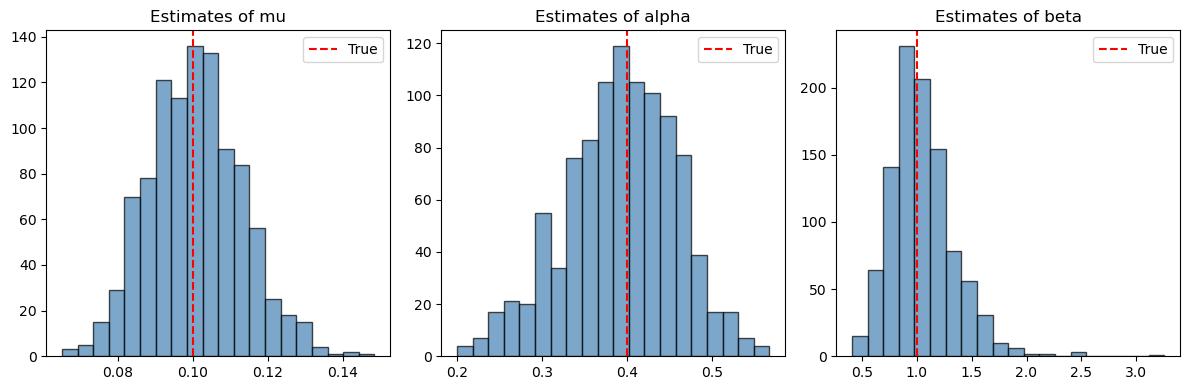

In [26]:
if __name__ == "__main__":
    df = test_mle_statistics(
        true_para={"mu": 0.1, "alpha": 0.4, "beta": 1.0},
        itv=[0, 1000],
        num_runs=1_000,
        verbose=True  # see which runs fail
    )

## Branching Algorithm :

In [27]:
def test_mle_on_branching_simulator(
    true_para={"mu": 0.2, "alpha": 0.5, "beta": 2.0},
    itv=[0, 100],
    num_runs=100,
    verbose=False
):
    def get_param(x):
        if isinstance(x, (list, np.ndarray)):
            return x[0]
        return x

    # Extraction des vrais paramètres
    mu = true_para["mu"]
    alpha = true_para["alpha"]
    beta = true_para["beta"]

    estimates = []

    for i in tqdm(range(num_runs), desc="Branching MLE"):
        # Simulation des événements avec le simulateur branching défini
        events, _ = simulate_hawkes_branching(mu, alpha, beta, Tmax=itv[1])

        # Restriction de l’échantillon à l’intervalle souhaité
        T = events[(events > itv[0]) & (events < itv[1])]

        # Vérification qu’il y a suffisamment d’événements
        if len(T) < 5:
            if verbose:
                print(f"Run {i}: trop peu d’événements ({len(T)}), ignoré.")
            continue

        # Estimation par MLE (via tick ou autre outil)
        h2 = hk.estimator().set_kernel('exp').set_baseline('const')
        try:
            h2.fit(T, itv)
            est_para = h2.para
            estimates.append([
                get_param(est_para["mu"]),
                get_param(est_para["alpha"]),
                get_param(est_para["beta"])
            ])
        except Exception as e:
            if verbose:
                print(f"Run {i} failed: {e}")
            continue

    if not estimates:
        print("\n Aucune estimation réussie. Essayez d’augmenter μ ou Tmax.")
        return None

    # Analyse des estimations
    estimates = np.array(estimates)
    df = pd.DataFrame(estimates, columns=["mu", "alpha", "beta"])

    print(f"\n Simulations réussies : {len(df)} sur {num_runs}")
    print("Paramètres vrais :", true_para)
    print("\nMoyennes estimées :\n", df.mean())
    print("\nÉcarts-types :\n", df.std())
    print("\nBiais (moyenne - vrai) :\n", df.mean() - pd.Series(true_para))

    # Histogrammes des paramètres estimés
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, param in enumerate(["mu", "alpha", "beta"]):
        axs[i].hist(df[param], bins=20, color='orchid',\
                     edgecolor='k', alpha=0.7)
        axs[i].axvline(true_para[param], color='red',\
                        linestyle='--', label='True')
        axs[i].set_title(f"Estimates of {param}")
        axs[i].legend()
    plt.tight_layout()
    plt.show()

    return df


Branching MLE: 100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]



 Simulations réussies : 1000 sur 1000
Paramètres vrais : {'mu': 0.1, 'alpha': 0.4, 'beta': 1.0}

Moyennes estimées :
 mu       0.100658
alpha    0.393723
beta     1.081454
dtype: float64

Écarts-types :
 mu       0.012439
alpha    0.064978
beta     0.310580
dtype: float64

Biais (moyenne - vrai) :
 mu       0.000658
alpha   -0.006277
beta     0.081454
dtype: float64


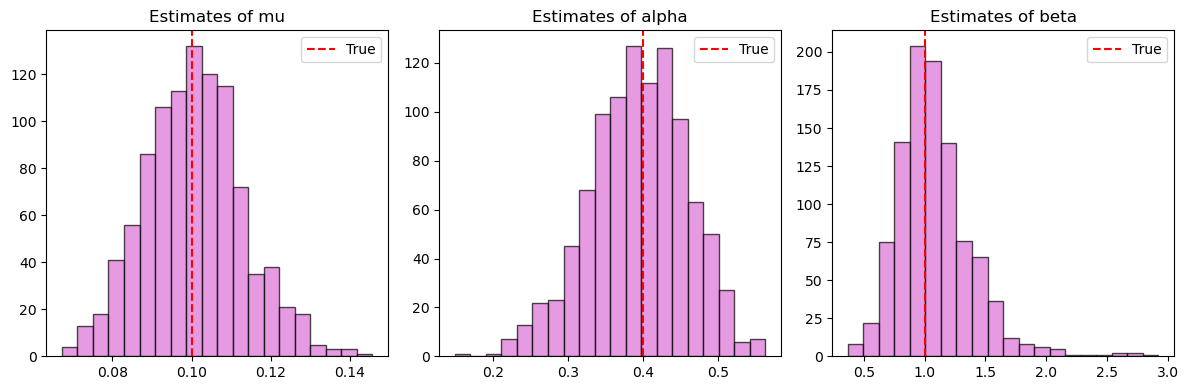

In [28]:
df_branching = test_mle_on_branching_simulator(
    true_para={"mu": 0.1, "alpha": 0.4, "beta": 1.0},
    itv=[0, 1000],
    num_runs=1000,
    verbose=True
)

## Comparaison des méthodes de simulation du processus de Hawkes

### Paramètres vrais :
- μ = 0.1  
- α = 0.4  
- β = 1.0  
- Nombre de simulations : 1000  
- Intervalle d’observation : [0, 1000]

---

### Résultats résumés

| Méthode                      | Moyenne μ | Moyenne α | Moyenne β | Biais μ  | Biais α  | Biais β  | Écart-type β | Temps approx. |
|-----------------------------|-----------|-----------|-----------|----------|----------|----------|----------------|----------------|
| Thinning (implémentation manuelle) | 0.0996    | 0.3950    | 1.0551    | -0.0004  | -0.0050  | +0.0551  | 0.3026         | ~36 sec         |
| Thinning (librairie optimisée)     | 0.0999    | 0.3945    | 1.0523    | -0.0001  | -0.0055  | +0.0523  | 0.2790         | ~3 sec          |
| Branching (implémentation manuelle)| 0.0998    | 0.3938    | 1.0365    | -0.0002  | -0.0062  | +0.0365  | 0.2679         | ~57 sec         |

---

### Analyse

- Les trois méthodes fournissent des estimations très proches des paramètres vrais, avec des biais faibles pour μ et α.
- La méthode **branching** présente le biais le plus faible sur β, ainsi que l’écart-type le plus bas, ce qui suggère une estimation légèrement plus stable pour ce paramètre.
- L’approche via une **librairie optimisée** (probablement basée sur Cython) est nettement plus rapide que les implémentations manuelles.
- La méthode **thinning manuelle** offre un bon compromis entre précision et simplicité d’implémentation.

---

### Conclusion

- Pour des analyses causales ou des modélisations explicites des générations : la méthode **branching** est la plus adaptée.
- Pour des simulations rapides à grande échelle : utiliser une **librairie optimisée** est préférable.
- L’implémentation **thinning manuelle** reste fiable et simple à comprendre pour l’expérimentation et l’enseignement.


### 3. A Hawkes process for trades. Is a Hawkes process a good model for the time dynamics of the trades reported in your dataset ? Use statistical arguments to support your answers.

In [29]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

files = get_all_files(os.path.join('Data', 'SG'))

dfs = []

for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('Data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    #if i == 1:
        #break  # < ----------------- remove this line to read all files
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df = df.sort_values(by='ets')
df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


In [30]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['ets'] = pd.to_datetime(df_trades['ets'])
df_trades = df_trades.set_index('ets').sort_index()

df_trades = df_trades.between_time('09:00:00', '17:30:00')

def add_daily_durations(group):
    group = group.sort_index()
    group['trade_duration'] = group.index.to_series().diff().dt.total_seconds()
    return group

df_trades = df_trades.groupby(df_trades.index.date, group_keys=False
                              ).apply(add_daily_durations)


df_trades = df_trades.dropna(subset=['trade_duration']) #first trade of each day

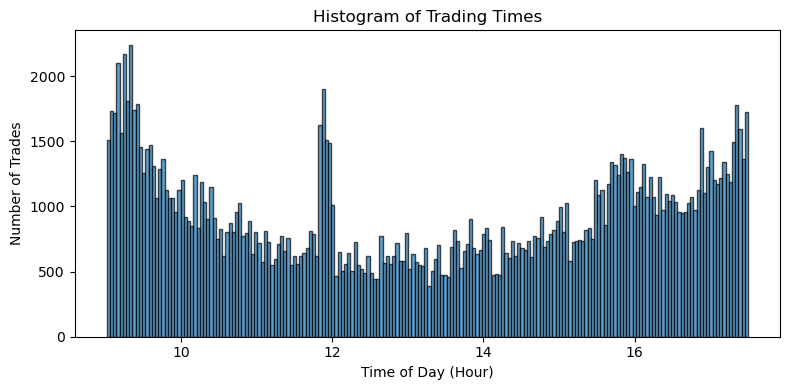

In [31]:
trade_times = df_trades.index.time
trade_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in trade_times]

plt.figure(figsize=(8, 4))
plt.hist(trade_hours, bins=200, edgecolor='black', alpha=0.7)
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Number of Trades')
plt.title('Histogram of Trading Times')
plt.tight_layout()
plt.show()

Typical U-Shaped of trades through time

In [32]:
timestamps = df_trades.index.sort_values()

t0 = timestamps[0]
T_array = (timestamps - t0).total_seconds().to_numpy()

st = 0.0
en = (timestamps[-1] - t0).total_seconds()
print("Number of trades:", len(T_array), "time window:", (st, en))

Number of trades: 187549 time window: (0.0, 1326529.100287)


Fitted parameters: {'mu': np.float64(0.06382718422580341), 'alpha': np.float64(0.5485472054209865), 'beta': np.float64(25066.17014707685)}
Branching ratio: 0.5485472054209865
Log-likelihood: 527573.4995810575
AIC: -1055140.999162115


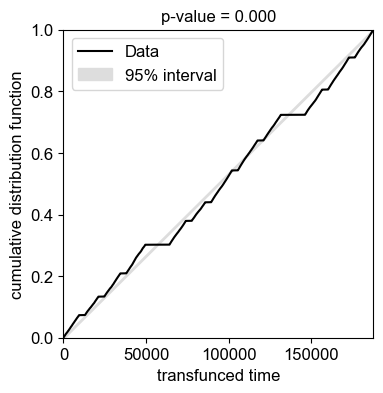

In [33]:
model_exp_const = hk.estimator()\
    .set_kernel('exp', num_exp=1)\
    .set_baseline('const')

model_exp_const.fit(T_array, [st, en])

print("Fitted parameters:", model_exp_const.parameter)
print("Branching ratio:", model_exp_const.br)
print("Log-likelihood:", model_exp_const.L)
print("AIC:", model_exp_const.AIC)

# Diagnostics
#model_exp_const.plot_N_enhanced()    # Observed N(t)
#model_exp_const.plot_l_enhanced()    # Fitted intensity \lambda(t)
model_exp_const.plot_KS()   # KS plot for time-rescaled events
plt.show()

Following the previous analysis, the model is not a good fit for the Kolmogorov-Smirnov plot. Since the p-value is lower than 0.05, it means that the null hypothesis (that the rescaled times follow the expected exponential distribution) is rejected. This suggests that the Hawkes process does not fully capture the structure of the trade arrival dynamics in this dataset. Although the branching ratio of ~0.55 indicates moderate self-excitation, the extremely fast decay rate (β ≈ 25,066) implies that the influence of past events dissipates almost instantly. In fact, the excitation half-life is approximately 27 microseconds, which may be too short to realistically model the inter-trade dependencies in high-frequency trading.

In [34]:
def cumulative_intensity(t, lambda0, alpha, beta):

    n = len(t)
    A = np.zeros(n)
    cumulative_Lambda = np.zeros(n - 1)

    # Initial condition
    A[0] = 1

    # Compute A(i) recursively
    for i in range(1, n):
        A[i] = 1 + np.exp(-beta * (t[i] - t[i - 1])) * A[i - 1]

    # Compute cumulative intensity between events
    for i in range(1, n):
        integral_baseline = lambda0 * (t[i] - t[i - 1])
        excitation_part = (alpha / beta) * \
              (1 - np.exp(-beta * (t[i] - t[i - 1]))) * A[i - 1]
        cumulative_Lambda[i - 1] = integral_baseline + excitation_part

    return cumulative_Lambda

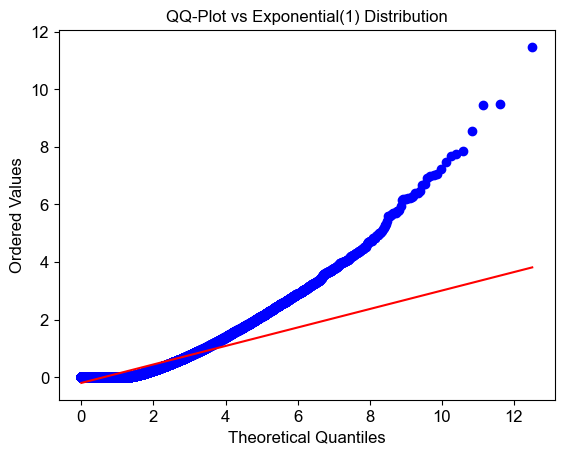

In [35]:
lambda_0 = model_exp_const.parameter['mu']
alpha = model_exp_const.parameter['alpha']
beta = model_exp_const.parameter['beta']

time_changed_data = cumulative_intensity(T_array, lambda_0, alpha, beta)

time_changed_data_filtered = np.array(list(
    filter(lambda x: x < 1000, time_changed_data)
))

sp.stats.probplot(time_changed_data_filtered, dist="expon",\
                   sparams=(0, 1), plot=plt)
plt.title("QQ-Plot vs Exponential(1) Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()

In [36]:
def compute_intensity_intraday(T_array, kernel_func, mu, x_grid):
    l_values = []
    for t in x_grid:
        past_events = T_array[T_array < t]
        dt = t - past_events
        kernel_sum = np.sum(kernel_func(dt))
        l_values.append(mu + kernel_sum)
    return np.array(l_values), np.full_like(x_grid, mu)

C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\2083942026.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


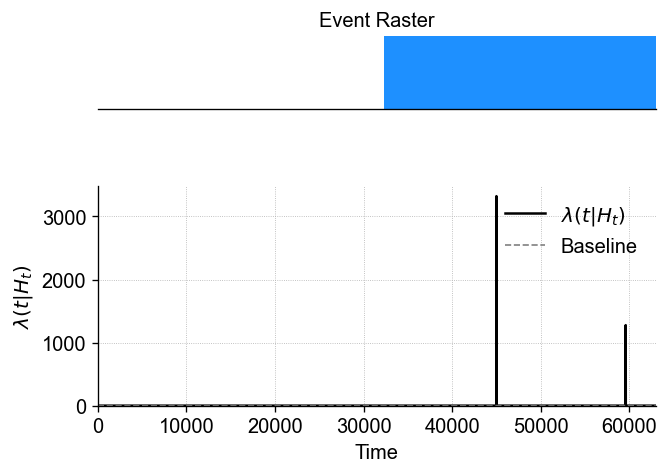

In [37]:
model_exp_const = hk.estimator()\
    .set_kernel('exp', num_exp=1)\
    .set_baseline('const')

# Make sure this is run before accessing parameters
model_exp_const.fit(T_array, [st, en])  

params = model_exp_const.parameter
alpha = params['alpha']
beta = params['beta']
lambda_0 = params['mu']

def exponential_kernel(dt):
    return alpha * beta * np.exp(-beta * dt)

T_array = (df_trades.index - df_trades.index.normalize()).total_seconds().values

st, en = 0.0, T_array[-1]
x = np.linspace(st, en, 5000)

l, l_baseline = compute_intensity_intraday(T_array,
                                           exponential_kernel,
                                           lambda_0, x)

plot_l_enhanced(T_array, x, l, l_baseline)

C:\Users\Marti\AppData\Local\Temp\ipykernel_19020\2083942026.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


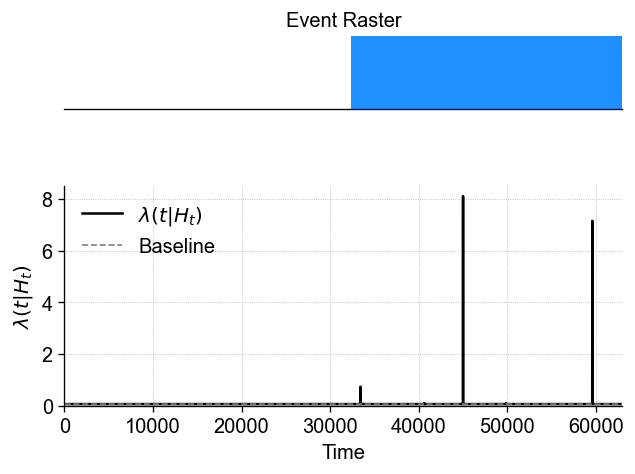

In [38]:
l_log = np.log1p(l)  # log(1 + λ) to include 0s safely
l_baseline_log = np.log1p(l_baseline)

plot_l_enhanced(T_array, x, l_log, l_baseline_log)

In [39]:
print(np.unique(l))

[6.38271842e-02 6.38271842e-02 6.38271842e-02 6.38271842e-02
 6.38271863e-02 6.38271896e-02 6.38322551e-02 6.42044924e-02
 6.45365525e-02 9.23844581e-02 1.04796834e-01 1.07909627e+00
 1.27688873e+03 3.32237318e+03]


The few sharp spikes represent moments where trades arrive so closely together that the self-excitation term momentarily amplifies intensity — but only for an extremely short time.

The KS test rejection (p=0.000) and this visualization both suggest that the model is too reactive, likely overfitting the micro-bursts and failing to capture broader dependencies but it's probably as we saw in TD1 because we are not modeling the microstructure events in a good way : meaning 